# Lab 4c. Deep Learning - iNaturalist
### Desik Somasundaram

## Import packages

In [18]:
import keras
import os, shutil
import pandas
from random import sample
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
import matplotlib.pyplot as plt
keras.__version__

'2.6.0'

## Explore data

In [19]:
# Examine original iNat data
os. getcwd() 
dir_train_mini = "/courses/EDS232/inaturalist-2021/train_mini"
dirs_spp = os.listdir(dir_train_mini)
n_spp = len(dirs_spp) # 10,000 species directories
n_spp 

10000

In [20]:
# Sample 10 species randomly
i10 = sample(range(1,n_spp),10)
i10

[7099, 6511, 428, 2083, 8108, 5589, 1846, 7149, 1608, 4723]

In [21]:
# show/select the first 2 species directory names from random 10
i2 = i10[0:2]

## Copy over, Read in and Prep data

In [23]:
# The path to the directory where the original
# dataset was uncompressed
original_dataset_dir = '/Users/desik/github/lab4-ml-deeplearning/data/train_mini'

# The directory where we will
# store our smaller dataset
base_dir = '/Users/desik/github/lab4-ml-deeplearning/data/train_mini_subset'
# this line clears the base dir, comment out if you don't want to start over
#shutil.rmtree(base_dir)
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

In [24]:
# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
if not os.path.exists(train_dir):
    os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
if not os.path.exists(validation_dir):
    os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)

In [25]:
# Select 2 species for first two parts of lab
speciesfolders = []
for i in i2:
    speciesfolders.append(os.path.basename(dirs_spp[i]))
speciesfolders

['06235_Plantae_Tracheophyta_Liliopsida_Poales_Cyperaceae_Carex_cherokeensis',
 '05776_Plantae_Rhodophyta_Florideophyceae_Corallinales_Corallinaceae_Corallina_officinalis']

In [26]:
# Create directories for each species in train, validation and test subfolders
# Get filenames for each species in original dataset
train_species_folders = []
validation_species_folders = []
test_species_folders = []
speciesfnames = []

# selected train, validation and test data sizes
n_train = 30
n_validation = 10
n_test = 10

# iterates through the two species selected in i2
i = 0
while i < len(i2):
    train_species_dir = os.path.join(train_dir, speciesfolders[i])
    train_species_folders.append(train_species_dir)
    if not os.path.exists(train_species_dir):
        os.mkdir(train_species_dir)
    validation_species_dir = os.path.join(validation_dir, speciesfolders[i])
    validation_species_folders.append(validation_species_dir)
    if not os.path.exists(validation_species_dir):
        os.mkdir(validation_species_dir)
    test_species_dir = os.path.join(test_dir, speciesfolders[i])
    test_species_folders.append(test_species_dir)
    if not os.path.exists(test_species_dir):
        os.mkdir(test_species_dir)
    n = 0
    for files in os.walk(os.path.join(original_dataset_dir, speciesfolders[i]), topdown=False):
       for name in files:
            n = n + 1
            if n > 2:
                speciesfnames.append(name)
    i = i + 1

In [27]:
# Copy over original data and split into train, validation and test based on specified sizes
i = 0
while i < len(i2):
    n = 0
    for fname in speciesfnames[i]:
        src = os.path.join(original_dataset_dir, speciesfolders[i], fname)
        if n < n_train:
            dst = os.path.join(train_species_folders[i], fname)
            n = n + 1
        elif n < n_train + n_validation:
            dst = os.path.join(validation_species_folders[i], fname)
            n = n + 1
        elif n < (n_train + n_validation + n_test):
            dst = os.path.join(test_species_folders[i], fname)
            n = n + 1
        shutil.copyfile(src, dst)
    i = i + 1

In [28]:
# sanity check on sizes of data splits
print('total training species 1 images:', len(os.listdir(train_species_folders[0])))

total training species 1 images: 30


In [29]:
# sanity check on sizes of data splits
print('total test species 2 images:', len(os.listdir(test_species_folders[1])))

total test species 2 images: 10


In [30]:
# sanity check on sizes of data splits
print('total validation species 2 images:', len(os.listdir(validation_species_folders[1])))

total validation species 2 images: 10


In [31]:
# sanity check on sizes of data splits
print('total test species 1 images:', len(os.listdir(test_species_folders[0])))

total test species 1 images: 10


## 2 Species (binary classification) - neural net

In [32]:
# image preprocessing for model with binary classificaiotn
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=4,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=4,
        class_mode='binary')

Found 60 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [33]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (4, 150, 150, 3)
labels batch shape: (4,)


### Neural net model

In [34]:
# Build neural net model
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(150, 150, 3)))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


2022-02-27 21:19:28.374120: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/R/4.0.5/lib/R/lib::/lib:/usr/local/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/java-11-openjdk-amd64/lib/server
2022-02-27 21:19:28.374159: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-27 21:19:28.374181: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (taylor): /proc/driver/nvidia/version does not exist
2022-02-27 21:19:28.374506: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the ap

In [35]:
# default optimizer and loss/metrics
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
# custom optimizer

#model.compile(optimizer=optimizers.RMSprop(lr=0.001),
#              loss='binary_crossentropy',
#             metrics=['accuracy'])

# custom optimizer and custom loss/metrics

#model.compile(optimizer=optimizers.RMSprop(lr=0.001),
#             loss=losses.binary_crossentropy,
#             metrics=[metrics.binary_accuracy])

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 150, 150, 16)      64        
_________________________________________________________________
flatten (Flatten)            (None, 360000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                5760016   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 5,760,097
Trainable params: 5,760,097
Non-trainable params: 0
_________________________________________________________________


In [37]:
# model fit
history = model.fit(
      train_generator,
      steps_per_epoch=5,
      epochs=40,
      validation_data=validation_generator,
      validation_steps=5)

2022-02-27 21:19:31.575051: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40
5/5 [==============================] - 1s 97ms/step - loss: 35.1115 - accuracy: 0.5500 - val_loss: 1.8091 - val_accuracy: 0.8000
Epoch 2/40
5/5 [==============================] - 0s 61ms/step - loss: 7.0737 - accuracy: 0.7500 - val_loss: 56.6506 - val_accuracy: 0.5000
Epoch 3/40
5/5 [==============================] - 0s 65ms/step - loss: 38.3755 - accuracy: 0.4500 - val_loss: 23.6992 - val_accuracy: 0.5000
Epoch 4/40
5/5 [==============================] - 0s 70ms/step - loss: 11.3760 - accuracy: 0.6000 - val_loss: 6.1677 - val_accuracy: 0.6500
Epoch 5/40
5/5 [==============================] - 0s 76ms/step - loss: 8.5052 - accuracy: 0.7000 - val_loss: 1.1875 - val_accuracy: 0.9000
Epoch 6/40
5/5 [==============================] - 0s 81ms/step - loss: 6.6877 - accuracy: 0.7500 - val_loss: 4.7679 - val_accuracy: 0.6500
Epoch 7/40
5/5 [==============================] - 0s 80ms/step - loss: 14.8489 - accuracy: 0.6000 - val_loss: 1.9658 - val_accuracy: 0.7000
Epoch 8/40
5/5 [=====

In [38]:
# find keys for history dictionary
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [183]:
model.save('2Species-binaryclassification-neuralnet.h5')

In [39]:
# neural net: accuracy metric and validation in the fitting process and history plot
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

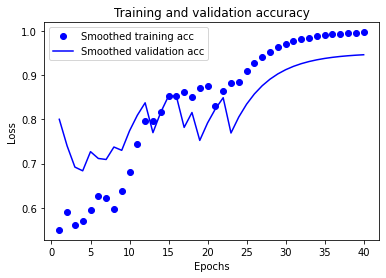

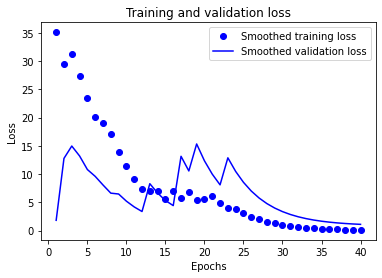

In [40]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points
plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [41]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=4,
        class_mode='binary')
test_loss, test_acc = model.evaluate_generator(test_generator, steps=5)
print('test acc:', test_acc)
print('test loss:', test_loss)

Found 20 images belonging to 2 classes.
test acc: 0.800000011920929
test loss: 1.6334426403045654


/opt/python/3.7.7/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


## 2 Species (binary classification) - convolutional neural net

In [42]:
# Build convolutional neural net model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

In [43]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)      

In [44]:
# model fit
history = model.fit(
      train_generator,
      steps_per_epoch=5,
      epochs=40,
      validation_data=validation_generator,
      validation_steps=5)

Epoch 1/40
5/5 [==============================] - 2s 245ms/step - loss: 0.8060 - acc: 0.4500 - val_loss: 0.7030 - val_acc: 0.5000
Epoch 2/40
5/5 [==============================] - 1s 140ms/step - loss: 0.7124 - acc: 0.5000 - val_loss: 0.6881 - val_acc: 0.5000
Epoch 3/40
5/5 [==============================] - 1s 116ms/step - loss: 0.7225 - acc: 0.5000 - val_loss: 0.6833 - val_acc: 0.5000
Epoch 4/40
5/5 [==============================] - 1s 98ms/step - loss: 0.6785 - acc: 0.6500 - val_loss: 0.6794 - val_acc: 0.5000
Epoch 5/40
5/5 [==============================] - 1s 121ms/step - loss: 0.7190 - acc: 0.6000 - val_loss: 0.6728 - val_acc: 0.5000
Epoch 6/40
5/5 [==============================] - 1s 109ms/step - loss: 0.6856 - acc: 0.5500 - val_loss: 0.6597 - val_acc: 0.5000
Epoch 7/40
5/5 [==============================] - 1s 107ms/step - loss: 0.6451 - acc: 0.6500 - val_loss: 0.6499 - val_acc: 0.5000
Epoch 8/40
5/5 [==============================] - 1s 125ms/step - loss: 0.6725 - acc: 0.700

In [41]:
model.save('2Species-binaryclassification-convnet.h5')

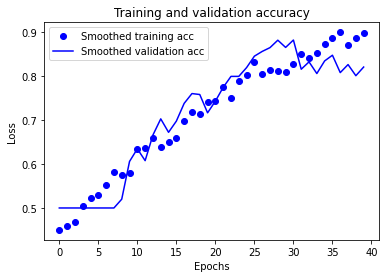

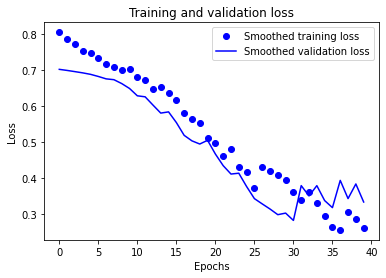

In [45]:
# conv net: accuracy metric and validation in the fitting process and history plot
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [46]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=4,
        class_mode='binary')
test_loss, test_acc = model.evaluate_generator(test_generator, steps=5)
print('test acc:', test_acc)
print('test loss:', test_loss)

Found 20 images belonging to 2 classes.
test acc: 0.949999988079071
test loss: 0.18705251812934875


## Write up comparing results-2 Species

The results from the standard neural network indicate a smaller test accuracy and a greater test loss than the convolutional neural network. This means that the convolutional neural network is making smaller errors and errors less frequently which is the desired result.

# 10 Species (multi-class classification) - neural net

In [47]:
# Select 10 species for second two parts of lab
speciesfolders = []
for i in i10:
    speciesfolders.append(os.path.basename(dirs_spp[i]))
speciesfolders

['06235_Plantae_Tracheophyta_Liliopsida_Poales_Cyperaceae_Carex_cherokeensis',
 '05776_Plantae_Rhodophyta_Florideophyceae_Corallinales_Corallinaceae_Corallina_officinalis',
 '09763_Plantae_Tracheophyta_Magnoliopsida_Vitales_Vitaceae_Vitis_riparia',
 '05978_Plantae_Tracheophyta_Liliopsida_Asparagales_Iridaceae_Iris_virginica',
 '06472_Plantae_Tracheophyta_Lycopodiopsida_Lycopodiales_Lycopodiaceae_Lycopodium_volubile',
 '09073_Plantae_Tracheophyta_Magnoliopsida_Myrtales_Onagraceae_Oenothera_suffulta',
 '06219_Plantae_Tracheophyta_Liliopsida_Liliales_Smilacaceae_Smilax_pumila',
 '06882_Plantae_Tracheophyta_Magnoliopsida_Asterales_Asteraceae_Lygodesmia_texana',
 '00938_Animalia_Arthropoda_Insecta_Lepidoptera_Crambidae_Samea_baccatalis',
 '02714_Animalia_Arthropoda_Malacostraca_Decapoda_Geryonidae_Ovalipes_ocellatus']

In [48]:
# Create directories for each species in train, validation and test subfolders
# Get filenames for each species in original dataset
train_species_folders = []
validation_species_folders = []
test_species_folders = []
speciesfnames = []

# selected train, validation and test data sizes
n_train = 30
n_validation = 10
n_test = 10

# iterates through the ten species selected in i10
i = 0
while i < len(i10):
    train_species_dir = os.path.join(train_dir, speciesfolders[i])
    train_species_folders.append(train_species_dir)
    if not os.path.exists(train_species_dir):
        os.mkdir(train_species_dir)
    validation_species_dir = os.path.join(validation_dir, speciesfolders[i])
    validation_species_folders.append(validation_species_dir)
    if not os.path.exists(validation_species_dir):
        os.mkdir(validation_species_dir)
    test_species_dir = os.path.join(test_dir, speciesfolders[i])
    test_species_folders.append(test_species_dir)
    if not os.path.exists(test_species_dir):
        os.mkdir(test_species_dir)
    n = 0
    for files in os.walk(os.path.join(original_dataset_dir, speciesfolders[i]), topdown=False):
       for name in files:
            n = n + 1
            if n > 2:
                speciesfnames.append(name)
    i = i + 1

In [49]:
# Copy over original data and split into train, validation and test based on specified sizes
i = 0
while i < len(i10):
    n = 0
    for fname in speciesfnames[i]:
        src = os.path.join(original_dataset_dir, speciesfolders[i], fname)
        if n < n_train:
            dst = os.path.join(train_species_folders[i], fname)
            n = n + 1
        elif n < n_train + n_validation:
            dst = os.path.join(validation_species_folders[i], fname)
            n = n + 1
        elif n < (n_train + n_validation + n_test):
            dst = os.path.join(test_species_folders[i], fname)
            n = n + 1
        shutil.copyfile(src, dst)
    i = i + 1

In [50]:
# sanity check on sizes of data splits
print('total training species 1 images:', len(os.listdir(train_species_folders[0])))

total training species 1 images: 30


In [51]:
# sanity check on sizes of data splits
print('total test species 3 images:', len(os.listdir(test_species_folders[2])))

total test species 3 images: 10


In [52]:
# sanity check on sizes of data splits
print('total validation species 9 images:', len(os.listdir(validation_species_folders[8])))

total validation species 9 images: 10


In [53]:
# image preprocessing for model with multi classificaiotn
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=4,
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=4,
        class_mode='categorical')

Found 300 images belonging to 10 classes.
Found 100 images belonging to 10 classes.


In [54]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (4, 150, 150, 3)
labels batch shape: (4, 10)


### Neural net model

In [68]:
# Build neural net model
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(150,150,3)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [69]:
# default optimizer and loss/metrics
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [70]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 150, 150, 128)     512       
_________________________________________________________________
flatten_4 (Flatten)          (None, 2880000)           0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               368640128 
_________________________________________________________________
dense_12 (Dense)             (None, 10)                1290      
Total params: 368,641,930
Trainable params: 368,641,930
Non-trainable params: 0
_________________________________________________________________


In [71]:
# model fit
history = model.fit(
      train_generator,
      steps_per_epoch=5,
      epochs=40,
      validation_data=validation_generator,
      validation_steps=5)

Epoch 1/40
5/5 [==============================] - 5s 1s/step - loss: 410.5391 - accuracy: 0.2000 - val_loss: 252.8813 - val_accuracy: 0.1000
Epoch 2/40
5/5 [==============================] - 5s 1s/step - loss: 211.2860 - accuracy: 0.0500 - val_loss: 134.4200 - val_accuracy: 0.0500
Epoch 3/40
5/5 [==============================] - 5s 1s/step - loss: 151.0981 - accuracy: 0.1000 - val_loss: 110.0734 - val_accuracy: 0.2000
Epoch 4/40
5/5 [==============================] - 5s 1s/step - loss: 81.0027 - accuracy: 0.1000 - val_loss: 53.0518 - val_accuracy: 0.1500
Epoch 5/40
5/5 [==============================] - 5s 1s/step - loss: 63.0937 - accuracy: 0.1000 - val_loss: 53.8170 - val_accuracy: 0.1000
Epoch 6/40
5/5 [==============================] - 6s 1s/step - loss: 59.6310 - accuracy: 0.2500 - val_loss: 54.3643 - val_accuracy: 0.1000
Epoch 7/40
5/5 [==============================] - 6s 1s/step - loss: 44.4146 - accuracy: 0.0500 - val_loss: 29.1422 - val_accuracy: 0.0500
Epoch 8/40
5/5 [=====

In [72]:
# find keys for history dictionary
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [84]:
model.save('10Species-multiclassification-neuralnet.h5')

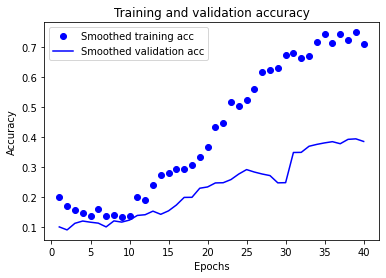

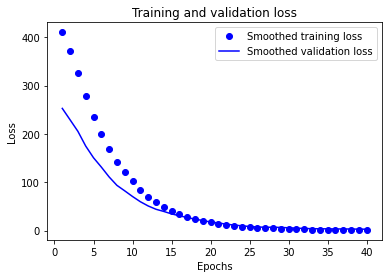

In [75]:
# neural net: accuracy metric and validation in the fitting process and history plot
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [74]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=4,
        class_mode='categorical')
test_loss, test_acc = model.evaluate_generator(test_generator, steps=5)
print('test acc:', test_acc)
print('test loss:', test_loss)

Found 100 images belonging to 10 classes.
test acc: 0.25
test loss: 2.7274413108825684


## 10 Species (multi classification) - convolutional neural net

In [141]:
# Build convolutional neural net model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [142]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 15, 15, 512)     

In [143]:
# model fit
history = model.fit(
      train_generator,
      steps_per_epoch=5,
      epochs=40,
      validation_data=validation_generator,
      validation_steps=5)

Epoch 1/40
5/5 [==============================] - 1s 145ms/step - loss: 2.6025 - accuracy: 0.0000e+00 - val_loss: 2.4567 - val_accuracy: 0.0000e+00
Epoch 2/40
5/5 [==============================] - 1s 122ms/step - loss: 2.3488 - accuracy: 0.1000 - val_loss: 2.3043 - val_accuracy: 0.0500
Epoch 3/40
5/5 [==============================] - 1s 110ms/step - loss: 2.3085 - accuracy: 0.0500 - val_loss: 2.2954 - val_accuracy: 0.2000
Epoch 4/40
5/5 [==============================] - 1s 108ms/step - loss: 2.2891 - accuracy: 0.2000 - val_loss: 2.3661 - val_accuracy: 0.0000e+00
Epoch 5/40
5/5 [==============================] - 1s 112ms/step - loss: 2.5881 - accuracy: 0.2500 - val_loss: 2.3239 - val_accuracy: 0.0500
Epoch 6/40
5/5 [==============================] - 1s 104ms/step - loss: 2.2362 - accuracy: 0.2000 - val_loss: 2.4329 - val_accuracy: 0.1000
Epoch 7/40
5/5 [==============================] - 0s 102ms/step - loss: 2.4060 - accuracy: 0.0000e+00 - val_loss: 2.2954 - val_accuracy: 0.1000
Epoc

In [140]:
model.save('10Species-multiclassification-convnet.h5')

In [98]:
# find keys for history dictionary
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

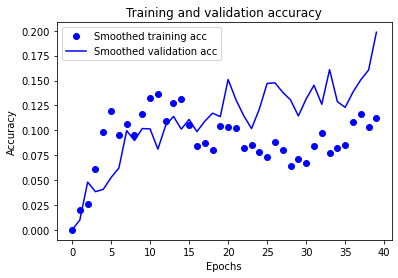

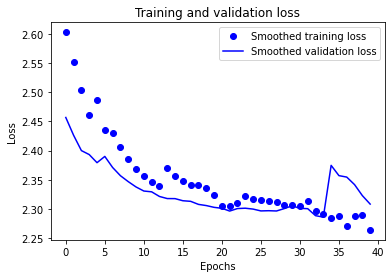

In [145]:
# conv net: accuracy metric and validation in the fitting process and history plot
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [148]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=4,
        class_mode='categorical')
test_loss, test_acc = model.evaluate_generator(test_generator, steps=5)
print('test acc:', test_acc)
print('test loss:', test_loss)

Found 100 images belonging to 10 classes.
test acc: 0.20000000298023224
test loss: 2.2656779289245605


## Write up comparing results-10 Species

The results from the standard neural network indicate a higher test accuracy and a slightly greater test loss than the convolutional neural network. This is a bit puzzling since the convolutional network is more complex and should perform better. The potential reasoning for the poor performance of the CNN in this case could be overfitting of the model. The CNN does not have enough input data to truly learn the distinctions between 10 different classes efficiently so more data would definitely impact these metrics.